# Reinforcement Learning Trading Agent to trade S&P 500 ETF
## What is the point of this code? 
### This code uses PPO algorithm from OpenAI's stable baselines to train agent to buy or sell S&P 500 ETF (SPY) on a daily basis.  We train the agent using five years worth of the past data and test it on the subsequent 1-month (most recent period).  
## Results:
###  We found that the reinforcement agent outperforms buy/hold by 1% or 12% annualized for that test month.  This is just an example.  The results are not robust.  One can learn from this code and add/remove features.  Try different training/test periods and/or different algorithms.  


In [1]:
# some useful libraries to install
#!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym
#!pip install quantstats
#!pip install finta
#!pip install yfinance
#!pip install yahoofinancials


# The most important libraries in the code below are

1. gym_anytrading.  This library has a custom stock trading environment that extends OpenAI gym. This allows us our agent to view the trading environment.  This environment can easily be extended for our purposes.  I can see two usecases for extension: one is adding features (which we do here) and two is ability to lever up (add more than) and buy and sell more than one contract of SPY. 

In [2]:
# Open AI gym and stablebaselines..

import gym
import gym_anytrading
import finta as TA #technical indicators library imported..
from gym_anytrading.envs import StocksEnv
import yfinance as yf


# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3 import PPO

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import quantstats as qs

# Pull SPY data from yfinance api..

In [3]:
#read spy data
df = yf.download('SPY', start='2017-01-01', end='2022-02-11', progress=False)
df.drop("Close", axis=1, inplace=True)
df.rename(columns = {'Adj Close':'Close'}, inplace = True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,225.039993,225.830002,223.880005,206.147552,91366500
2017-01-04,225.619995,226.750000,225.610001,207.373947,78744400
2017-01-05,226.270004,226.580002,225.479996,207.209198,78379000
2017-01-06,226.529999,227.750000,225.899994,207.950531,71559900
2017-01-09,226.910004,227.070007,226.419998,207.264114,46939700


In [4]:
df.dtypes
df.shape

(1287, 5)

In [5]:
#technical indicator creation
df['SMA'] = TA.TA.SMA(df,10)- TA.TA.SMA(df,5)
df['RSI'] = TA.TA.RSI(df)
df['OBV'] = TA.TA.OBV(df)
df['VAMA'] = TA.TA.VAMA(df)
df['HMA'] = TA.TA.HMA(df)
df['MOM'] = TA.TA.MOM(df)
df['ROC'] = TA.TA.ROC(df)
df['ATR'] = TA.TA.ATR(df)
df['ADX'] = TA.TA.ADX(df)
df['UO'] = TA.TA.UO(df)
df["1DayChange"]=df['Close'].diff()
#df["1DIFF2"]=df['1DayChange'].diff()
df["1WeekChange"]=df['Close'].diff(5)
df["1MonthChange"]=df['Close'].diff(21)
#df["vol"] = df['Close'].rolling(5).std()


# lifting prices forward by one day, so lagging feature variables
#df['Close'] = df['Close'].shift(-1)
#df['Open'] = df['Open'].shift(-1)
#df['High'] = df['High'].shift(-1)
#df['Low'] = df['Low'].shift(-1)


df.fillna(0,inplace=True)
df.drop(df.tail(1).index,inplace=True) # drop last n rows

df.tail(5)

,Open,High,Low,Close,Volume,SMA,RSI,OBV,VAMA,HMA,MOM,ROC,ATR,ADX,UO,1DayChange,1WeekChange,1MonthChange
Date,,,,,,,,,,,,,,,,,,
2022-02-03,450.950012,452.970001,445.709991,446.600006,118024400,-7.185004,44.302038,3.656842e+09,442.204710,444.912143,-0.149994,-2.166528,11.062855,31.274523,53.023726,-10.750000,15.360016,-30.949982
2022-02-04,446.350006,452.779999,443.829987,448.700012,118335600,-7.463004,46.115639,3.775178e+09,444.247159,448.455081,10.720001,-0.675149,11.331427,31.392660,55.658053,2.100006,6.750000,-19.679993
2022-02-07,449.510010,450.989990,445.850006,447.260010,84472900,-6.191003,45.032813,3.690705e+09,446.502079,450.639911,7.420013,0.114160,11.026426,31.502359,59.616165,-1.440002,-2.649994,-20.679993
2022-02-08,446.730011,451.920013,445.220001,450.940002,81012000,-4.142001,48.369284,3.771717e+09,449.153655,452.082151,16.470001,2.959037,10.922856,31.484463,57.363122,3.679993,-2.010010,-15.149994
2022-02-09,455.220001,457.880005,455.010010,457.540009,92589900,-1.764001,53.787154,3.864307e+09,451.440978,453.729180,24.160004,4.024193,10.401428,30.682629,57.740119,6.600006,0.190002,-7.970001


In [7]:

window_size = 1
start_index = window_size
end_index = 1265
env = gym.make('stocks-v0', df=df, frame_bound=(start_index,end_index), window_size=window_size)

def add_signals(env):
    #calculate the starting index, getting our first frame value, start at 0
    #frame bound is equal to one.  Env.Window_size is also equal to one.  Thus, we are starting at zero
    start = env.frame_bound[0]-env.window_size
    
    #getting the end of our frame, which in this case is 200
    end = env.frame_bound[1]
    #get prices from our start to our end
    prices = env.df.loc[:,'Close'].to_numpy()[start:end]
    #signal_features = env.df.loc[:,['SMA', 'RSI','OBV','VAMA','HMA','MOM','ROC','ATR','ADX','UO','1DayChange','1WeekChange','1MonthChange']].to_numpy()[start:end]
    signal_features = env.df.loc[:,['Close','1DayChange','1WeekChange','1MonthChange','ATR']].to_numpy()[start:end]
    

    return prices, signal_features

class MyCustomEnv(StocksEnv):
    _process_data = add_signals


env = MyCustomEnv(df=df, window_size =window_size, frame_bound=(start_index,end_index))


# 2. Build Environment

In [8]:
env.action_space

Discrete(2)

info {'total_reward': 59.94622802734375, 'total_profit': 0.009222888604291117, 'position': 1}


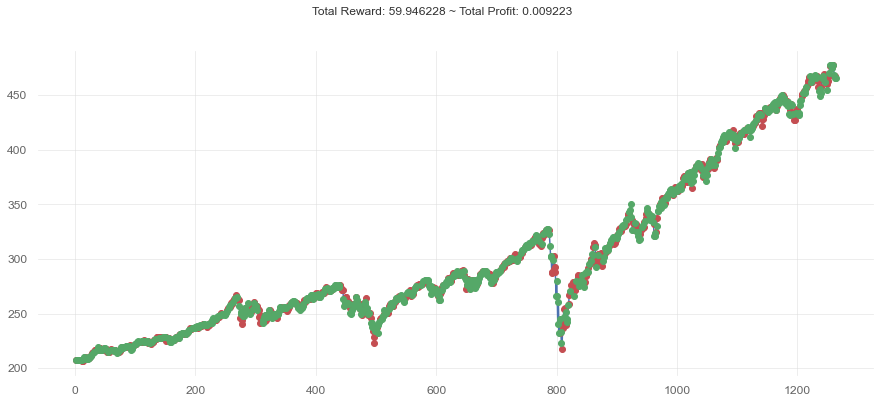

In [9]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# 3. Build Environment and Train

In [10]:
window_size = 1
start_index = window_size
end_index = 1265

env_maker = lambda: env
env = DummyVecEnv([env_maker])

In [11]:
model = PPO('MlpPolicy', env, verbose=1, seed=100) 
#model = A2C('MlpPolicy', env, verbose=1, seed=100)
model.learn(total_timesteps=50000)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 765  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 483        |
|    iterations           | 2          |
|    time_elapsed         | 8          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01684537 |
|    clip_fraction        | 0.0468     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.68      |
|    explained_variance   | -0.00226   |
|    learning_rate        | 0.0003     |
|    loss                 | 16.4       |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.00342   |
|    value_loss           | 39.9       |
----------------------------------------
-----------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 393          |
|    iterations           | 13           |
|    time_elapsed         | 67           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0054659676 |
|    clip_fraction        | 0.00693      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.53        |
|    explained_variance   | 0.276        |
|    learning_rate        | 0.0003       |
|    loss                 | 22.9         |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00229     |
|    value_loss           | 53.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 392          |
|    iterations           | 14           |
|    time_elapsed         | 73           |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 386          |
|    iterations           | 24           |
|    time_elapsed         | 127          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0010479945 |
|    clip_fraction        | 0.0137       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.578       |
|    explained_variance   | 0.462        |
|    learning_rate        | 0.0003       |
|    loss                 | 38.2         |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.00172     |
|    value_loss           | 45.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 386          |
|    iterations           | 25           |
|    time_elapsed         | 132          |
|    total_

# 4. Evaluation

In [392]:
window_size = 1
start_index = 1265+window_size
end_index = 1286
#start_index = window_size
#end_index = 1265

env = MyCustomEnv(df=df, window_size=window_size, frame_bound=(start_index, end_index))
#env = gym.make('stocks-v0', df=df, frame_bound=(start_index,end_index), window_size=window_size)

obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    #print(obs)
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    #print(action)
    print(obs)
    print(info)
    if done:
        print("info", info)
        break

[[471.01998901   1.26998901   2.63998413   6.08340454   5.12214443]]
{'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}
[[464.52999878  -6.48999023  -3.41000366   2.79220581   5.47500174]]
{'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}
[[ 4.64720001e+02  1.90002441e-01 -1.36999512e+00 -4.23245239e+00
   5.36643110e+00]]
{'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}
[[456.48999023  -8.23001099  -9.02001953  -8.32699585   5.84214565]]
{'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}
[[451.75        -4.73999023 -18.          -8.11999512   6.23571777]]
{'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}
[[446.75        -5.         -24.26998901  -8.23001099   7.01500375]]
{'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}
[[437.98001099  -8.76998901 -26.54998779 -25.07998657   7.58071899]]
{'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}
[[439.83999634   1.85998535 -24.88000488 -27.8500061    8.69643293]]
{'total_reward': 0.0, 'to

AttributeError: 'DummyVecEnv' object has no attribute 'render_all'

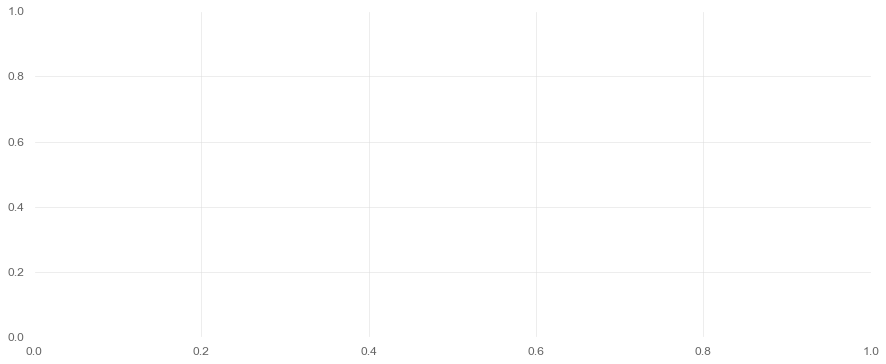

In [363]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()
env.prices

In [ ]:
qs.extend_pandas()


net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
#qs.reports.html(returns, output='a2c_quantstats.html')


In [ ]:
state = env.reset()
while True: 
    action = 1
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()